# TF Hub 와 전이학습

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import tensorflow_hub as hub
from tensorflow import feature_column as fc
from tensorflow.keras import layers
import tensorflow_datasets as tfds

plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Tf Hub로 분류기 다운로드해서 즉시 예측하기

In [19]:
# 준비 : imagenet label

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


input: (224, 224, 3)
output: (1, 1001)


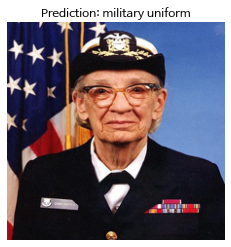

In [71]:
def mobilenet_classifier_from_tfhub():
    
    IMAGE_SHAPE = (224,224)
    
    # 사전 학습된 모델 확보 
    classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
    classifier = tf.keras.Sequential([
        hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3,))
    ])
    
    # 테스트 이미지 확보 
    import numpy as np
    import PIL.Image as Image
    
    grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
    grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
    grace_hopper = np.array(grace_hopper)/255.0
    print('input:', grace_hopper.shape)
    
    # 예측 수행
    result = classifier.predict(grace_hopper[np.newaxis, ...])
    print('output:', result.shape)
    predicted_class = np.argmax(result[0], axis=-1)
    
    plt.imshow(grace_hopper)
    plt.axis('off')
    plt.title('Prediction: ' + imagenet_labels[predicted_class])

    return classifier
pretrained_classifier = mobilenet_classifier_from_tfhub()

## 전이 학습

### Flower 데이터셋 준비

In [72]:
def prepare_flower_data():
    
    IMAGE_SHAPE = (224,224)
    
    data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
        untar=True)
    print(data_root)
    
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
    image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)
    
    return image_data

image_data = prepare_flower_data()
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

/home/hoondori/.keras/datasets/flower_photos
Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### 전이 학습 없이 예측

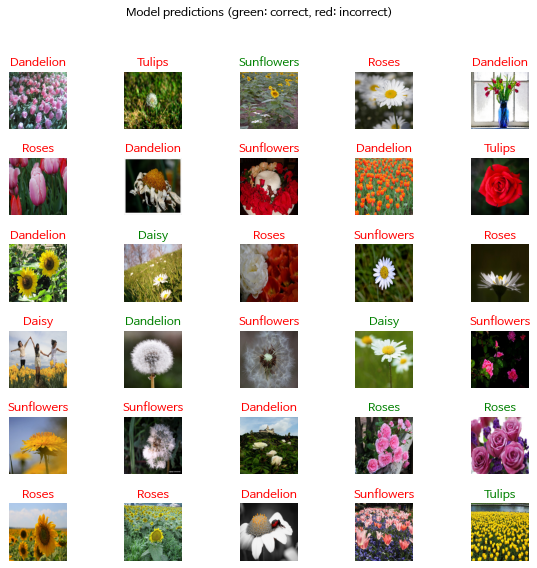

In [73]:
result_batch = pretrained_classifier.predict(image_batch)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
label_id = np.argmax(label_batch, axis=-1)

# plt.figure(figsize=(10,9))
# plt.subplots_adjust(hspace=0.5)
# for n in range(30):
#     plt.subplot(6,5,n+1)
#     plt.imshow(image_batch[n])
#     plt.title(predicted_class_names[n])
#     plt.axis('off')
#     _ = plt.suptitle("ImageNet predictions")
    
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")    

## 전이학습 수행 

In [74]:
feature_extractor_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2",
    input_shape=(224,224,3)
)
feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_23 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [75]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()
    
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy', metrics=['acc'])


step_per_epoch = np.ceil(image_data.samples/image_data.batch_size)    
batch_callbacks = CollectBatchStats()

history = model.fit(
    image_data,
    epochs=2,
    callbacks=[batch_callbacks]
)

Epoch 1/2
115/115 [==============================] - 19s 165ms/step - loss: 0.2589 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 19s 165ms/step - loss: 0.4000 - acc: 0.8125


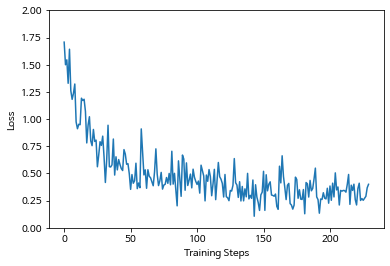

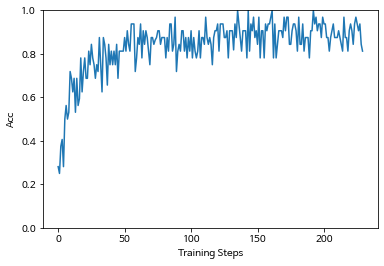

In [76]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_callbacks.batch_losses)


plt.figure()
plt.ylabel('Acc')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(batch_callbacks.batch_acc)

## 전이학습된 모델로 예측 

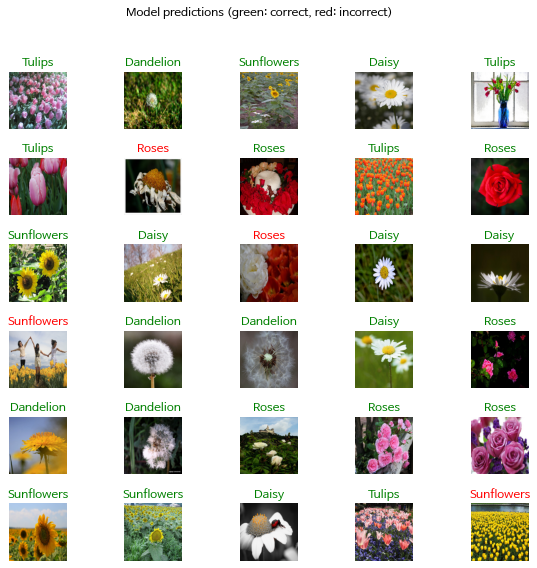

In [77]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")